## Finetuning CNNs [1]

A key observation from the learned weights of CNNs is that the intial layers learn a generic set of features (edges, gabor like) while the towards the classifier layer, the features become more specific to the given task. Hence one can use these pretrained features from say alexnet trained on ImageNet dataset as it is to a newer problem.

In this tutorial, we will learn how to train the network using transfer learning [2] to further improve these features to our task. We will use alexnet architecture and our problem is defined as fine grained classification of bird images. To restrict the size of the dataset we will use a subset of [Caltech-UCSD Birds-200-2011](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) having only 10 classes.




In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import time
import copy
import os
import pdb

plt.ion()   # interactive mode

#Using the standard dataloaders and transformers
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '../../data/lab1/imgFolders/CUB_10_Subset'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()

In [2]:
#Printing the classes used in this tutorial
dsets['train'].classes

['003.Sooty_Albatross',
 '031.Black_billed_Cuckoo',
 '032.Mangrove_Cuckoo',
 '046.Gadwall',
 '069.Rufous_Hummingbird',
 '080.Green_Kingfisher',
 '125.Lincoln_Sparrow',
 '128.Seaside_Sparrow',
 '129.Song_Sparrow',
 '139.Scarlet_Tanager']

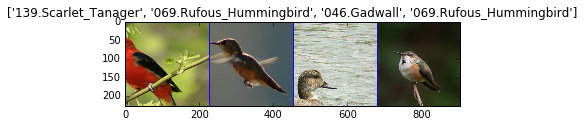

In [3]:
#Visualizing the datset images

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[dset_classes[x] for x in classes])


### Transfer Learning
![transfer-all](images/transfer-all.png)

In [4]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

######################################################################
# Learning rate scheduler
# ^^^^^^^^^^^^^^^^^^^^^^^
# Let's create our learning rate scheduler. We will exponentially
# decrease the learning rate once every few epochs.

def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer


######################################################################
# Visualizing the model predictions
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# Generic function to display predictions for a few images
#

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return


#### AlexNet Architecture
![alexnet](images/alexnet.png)

#### Loading AlexNet

In [5]:
#Loading alexNet architecture
model_ft = models.alexnet(pretrained=False)

#Reading weights from pretrained model
model_ft.load_state_dict(torch.load('../../data/lab1/pretrained/alexnet-owt-4df8aa71.pth'))

#Printing the architecture
for idx, m in enumerate(model_ft.modules()):
    print(idx, '->', m)

0 -> AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)
1 -> Sequential (
  (0)

#### Re-Initializing the last layer

In [6]:
## Note: If you want to re-run this code, run the previous code (loading the alexnet) again

mod = list(model_ft.classifier.children())
#remove the last softmax layer
mod.pop()

#initialize a new layer with dimension (4096,10)
mod.append(torch.nn.Linear(4096, 10))
new_classifier = nn.Sequential(*mod)

model_ft.classifier = new_classifier
print(model_ft)

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 10)
  )
)


Epoch 0/24
----------
LR is set to 0.001
train Loss: 0.3867 Acc: 0.5151
val Loss: 0.3933 Acc: 0.4983

Epoch 1/24
----------
train Loss: 0.3130 Acc: 0.5686
val Loss: 0.2997 Acc: 0.6564

Epoch 2/24
----------
train Loss: 0.3013 Acc: 0.5819
val Loss: 0.2405 Acc: 0.7079

Epoch 3/24
----------
train Loss: 0.2518 Acc: 0.6789
val Loss: 0.2335 Acc: 0.7010

Epoch 4/24
----------
train Loss: 0.2459 Acc: 0.6957
val Loss: 0.2429 Acc: 0.7113

Epoch 5/24
----------
train Loss: 0.2578 Acc: 0.6756
val Loss: 0.3137 Acc: 0.6117

Epoch 6/24
----------
train Loss: 0.2061 Acc: 0.6990
val Loss: 0.2855 Acc: 0.6838

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.1367 Acc: 0.7793
val Loss: 0.1820 Acc: 0.7629

Epoch 8/24
----------
train Loss: 0.1115 Acc: 0.8696
val Loss: 0.1645 Acc: 0.7973

Epoch 9/24
----------
train Loss: 0.0949 Acc: 0.8395
val Loss: 0.1594 Acc: 0.8041

Epoch 10/24
----------
train Loss: 0.0818 Acc: 0.8896
val Loss: 0.1489 Acc: 0.8213

Epoch 11/24
----------
train Loss: 0.0896 Acc: 

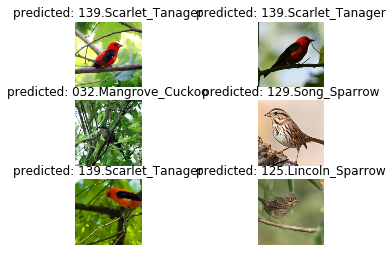

In [7]:
if use_gpu:
    #Model would take around 1.6GB GPU memory
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

visualize_model(model_ft)


#### ConvNet as fixed feature extractor
![transfer-freeze](images/transfer-freeze.png)
Here, we need to freeze all the network except the final layer. We need to set ``requires_grad == False`` to freeze the parameters so that the gradients are not computed in ``backward()``.

In [8]:
#Loading alexnet
model_conv = torchvision.models.alexnet(pretrained=False)
model_conv.load_state_dict(torch.load('../../data/lab1/pretrained/alexnet-owt-4df8aa71.pth'))

#Setting all require_grad param to false for all learnable parameters
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
mod = list(model_ft.classifier.children())
mod.pop()

mod.append(torch.nn.Linear(4096, 10))
new_classifier = nn.Sequential(*mod)

model_conv.classifier = new_classifier

Epoch 0/24
----------
LR is set to 0.001
train Loss: 0.3338 Acc: 0.6221
val Loss: 0.2713 Acc: 0.7045

Epoch 1/24
----------
train Loss: 0.1943 Acc: 0.7692
val Loss: 0.2000 Acc: 0.7732

Epoch 2/24
----------
train Loss: 0.1645 Acc: 0.8127
val Loss: 0.2065 Acc: 0.7663

Epoch 3/24
----------
train Loss: 0.1232 Acc: 0.8395
val Loss: 0.2144 Acc: 0.7663

Epoch 4/24
----------
train Loss: 0.1078 Acc: 0.8696
val Loss: 0.2019 Acc: 0.8041

Epoch 5/24
----------
train Loss: 0.0840 Acc: 0.8963
val Loss: 0.1903 Acc: 0.7973

Epoch 6/24
----------
train Loss: 0.0606 Acc: 0.9130
val Loss: 0.1940 Acc: 0.7904

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.0666 Acc: 0.9164
val Loss: 0.1870 Acc: 0.8076

Epoch 8/24
----------
train Loss: 0.0638 Acc: 0.9164
val Loss: 0.1820 Acc: 0.8179

Epoch 9/24
----------
train Loss: 0.0695 Acc: 0.9064
val Loss: 0.1790 Acc: 0.8282

Epoch 10/24
----------
train Loss: 0.0560 Acc: 0.9264
val Loss: 0.1750 Acc: 0.8282

Epoch 11/24
----------
train Loss: 0.0501 Acc: 

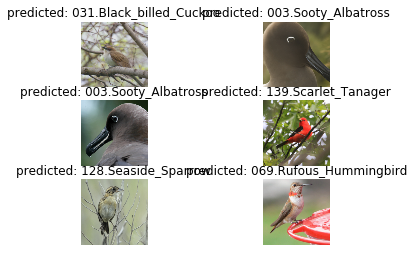

In [9]:
#Start fine tuning
if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.01, momentum=0.9)


model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

######################################################################
#

visualize_model(model_conv)

plt.ioff()
plt.show()

### References
[1] Sasank Chilamkurthy, [Transfer Learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) <br>
[2] [CS231n Convolutional Neural Networks for Visual Recognition.](http://cs231n.github.io/transfer-learning/) <br>

